## Redlining Impacts 80 Years Later

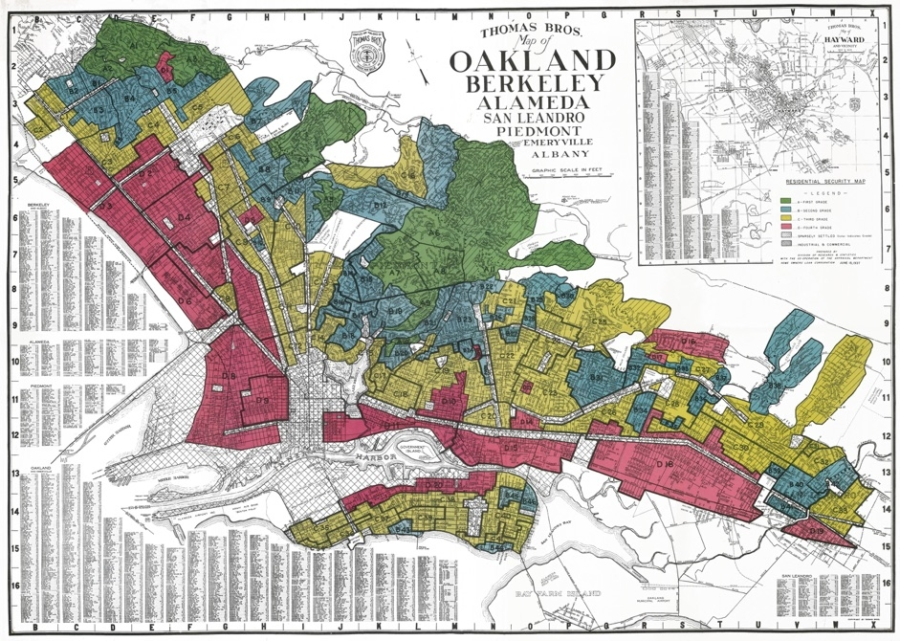

In [1]:
# general import statements 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly import express as px
from plotly.subplots import make_subplots

from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

The redlining dataset contains 2020 population total estimates by race/ethnicity for combined zones of each redlining grade (from Home Owners' Loan Corporation [HOLC] maps originally drawn in 1935-40, downloaded from the Mapping Inequality project) within micro- and metropolitan areas. Also included are population estimates in the surrounding area of each metropolitan area's HOLC map (computed by adding a 10 percent buffer radius to the minimum bounding circle of all zones in that metro area) and location quotients (LQs) for each racial/ethnic group and HOLC grade. LQs are small-area measures of segregation that specifically compare one racial/ethnic group’s proportion in a granular geography to their proportion in a larger surrounding geography. An LQ above 1 for a given racial group indicates overrepresentation in that HOLC zone relative to the broader surrounding area, and values below 1 indicate underrepresentation.

Population and race/ethnicity data comes from the 2020 U.S. decennial census. White, Black and Asian data excludes those who indicated Hispanic or Latino ethnicity. Hispanic/Latino data includes all who indicated Hispanic or Latino ethnicity, regardless of race. Other race data includes all population counts that did not fall under white, Black, Asian or Latino groups.

Only micro- and metropolitan areas with both A- (“best”) and D-rated (“hazardous”) zones in their redlining map are included — 138 of a total 143 metropolitan areas in the data from Mapping Inequality.

Location Quotient = (xim/xi)/(Xm/X) where xim is the population of a racial group m within a smaller geography i, xi is the total population of the same geography i, Xm is the population of the racial group m within a bigger geography e.g. MSA with smaller geographies i, and X is the total population of the bigger geography. A value of 1 for this measure suggests that the racial group m at the bigger geography has the same proportion as in the smaller geography. A value greater than 1 for this measure suggests that the racial group m has a higher concentration within the smaller geography compared to the bigger geography.

In [2]:
# import dataset and show first few lines:
redline = pd.read_csv('data/metro-grades.csv')
redline.head()

metro_area holc_grade  white_pop  black_pop  hisp_pop  \
0                    Akron, OH          A      24702       8624       956   
1                    Akron, OH          B      41531      16499      2208   
2                    Akron, OH          C      73105      22847      3149   
3                    Akron, OH          D       6179       6921       567   
4  Albany-Schenectady-Troy, NY          A      16989       1818      1317   

   asian_pop  other_pop  total_pop  pct_white  pct_black  ...  \
0        688       1993      36963      66.83      23.33  ...   
1       3367       4211      67816      61.24      24.33  ...   
2       6291       7302     112694      64.87      20.27  ...   
3        455       1022      15144      40.80      45.70  ...   
4       1998       1182      23303      72.91       7.80  ...   

   surr_area_white_pop  surr_area_black_pop  surr_area_hisp_pop  \
0               304399                70692               11037   
1               304399                70692               11037   
2               304399                70692               11037   
3               304399                70692               11037   
4               387016                68371               42699   

   surr_area_asian_pop  surr_area_other_pop  surr_area_pct_white  \
0                17295                23839                71.24   
1                17295                23839                71.24   
2                17295                23839                71.24   
3                17295                23839                71.24   
4                41112                40596                66.75   

   surr_area_pct_black  surr_area_pct_hisp  surr_area_pct_asian  \
0                16.55                2.58                 4.05   
1                16.55                2.58                 4.05   
2                16.55                2.58                 4.05   
3                16.55                2.58                 4.05   
4                11.79                7.36                 7.09   

   surr_area_pct_other  
0                 5.58  
1                 5.58  
2                 5.58  
3                 5.58  
4                 7.00  

[5 rows x 28 columns]

In [3]:
redline.shape

(551, 28)

--- 
### EDA: Exploratory Data Analysis

In [4]:
redline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   metro_area           551 non-null    object 
 1   holc_grade           551 non-null    object 
 2   white_pop            551 non-null    int64  
 3   black_pop            551 non-null    int64  
 4   hisp_pop             551 non-null    int64  
 5   asian_pop            551 non-null    int64  
 6   other_pop            551 non-null    int64  
 7   total_pop            551 non-null    int64  
 8   pct_white            551 non-null    float64
 9   pct_black            551 non-null    float64
 10  pct_hisp             551 non-null    float64
 11  pct_asian            551 non-null    float64
 12  pct_other            551 non-null    float64
 13  lq_white             551 non-null    float64
 14  lq_black             551 non-null    float64
 15  lq_hisp              551 non-null    flo

In [5]:
redline.describe()

white_pop      black_pop      hisp_pop      asian_pop  \
count  5.510000e+02     551.000000  5.510000e+02     551.000000   
mean   2.883897e+04   15735.141561  1.913983e+04    6216.865699   
std    8.615059e+04   62120.432859  1.065945e+05   41375.780585   
min    1.580000e+02       1.000000  6.000000e+00       1.000000   
25%    3.508500e+03     530.000000  4.075000e+02      82.500000   
50%    8.448000e+03    2380.000000  1.759000e+03     305.000000   
75%    2.175650e+04    8218.000000  6.920500e+03    1446.500000   
max    1.164087e+06  894704.000000  1.492338e+06  767862.000000   

           other_pop     total_pop   pct_white   pct_black    pct_hisp  \
count     551.000000  5.510000e+02  551.000000  551.000000  551.000000   
mean     3809.544465  7.374032e+04   55.452450   19.982958   15.540835   
std     14369.453531  2.970820e+05   22.478377   18.668535   16.861343   
min        10.000000  2.280000e+02    3.770000    0.310000    1.100000   
25%       354.000000  7.205000e+03   39.275000    5.865000    4.625000   
50%       992.000000  1.746000e+04   59.010000   13.390000    8.800000   
75%      2350.000000  4.338600e+04   74.710000   28.440000   19.885000   
max    239048.000000  4.558038e+06   94.120000   85.400000   93.900000   

        pct_asian  ...  surr_area_white_pop  surr_area_black_pop  \
count  551.000000  ...         5.510000e+02         5.510000e+02   
mean     3.231162  ...         3.198688e+05         1.199405e+05   
std      3.668255  ...         7.101621e+05         2.970600e+05   
min      0.090000  ...         8.715000e+03         1.080000e+03   
25%      0.995000  ...         4.715700e+04         1.113000e+04   
50%      2.010000  ...         9.246900e+04         3.077700e+04   
75%      3.910000  ...         2.489550e+05         8.325200e+04   
max     31.390000  ...         5.169444e+06         2.626933e+06   

       surr_area_hisp_pop  surr_area_asian_pop  surr_area_other_pop  \
count        5.510000e+02         5.510000e+02           551.000000   
mean         1.635487e+05         6.329608e+04         34257.604356   
std          6.202177e+05         2.535645e+05         81771.257893   
min          5.880000e+02         1.130000e+02          1248.000000   
25%          5.652000e+03         1.539000e+03          4450.000000   
50%          2.360300e+04         5.186000e+03          9243.000000   
75%          6.835700e+04         1.942600e+04         24755.000000   
max          5.415084e+06         2.077111e+06        675943.000000   

       surr_area_pct_white  surr_area_pct_black  surr_area_pct_hisp  \
count           551.000000           551.000000          551.000000   
mean             54.773285            20.051016           15.581833   
std              17.344710            15.192793           15.188106   
min              11.980000             2.070000            1.530000   
25%              42.080000             8.250000            5.390000   
50%              57.220000            16.550000            9.570000   
75%              66.970000            26.490000           21.000000   
max              89.110000            76.300000           81.200000   

       surr_area_pct_asian  surr_area_pct_other  
count           551.000000           551.000000  
mean              4.080708             5.513230  
std               4.227148             1.773156  
min               0.370000             1.800000  
25%               1.350000             4.340000  
50%               3.100000             5.310000  
75%               4.910000             6.430000  
max              29.210000            15.520000  

[8 rows x 26 columns]

In [6]:
redline[redline['metro_area']== 'San Diego-Chula Vista-Carlsbad, CA'][['metro_area','holc_grade','lq_white', 'lq_black', 'lq_hisp', 'lq_asian', 'lq_other']]


metro_area holc_grade  lq_white  lq_black  \
420  San Diego-Chula Vista-Carlsbad, CA          A      1.80      0.24   
421  San Diego-Chula Vista-Carlsbad, CA          B      1.64      0.40   
422  San Diego-Chula Vista-Carlsbad, CA          C      1.06      1.06   
423  San Diego-Chula Vista-Carlsbad, CA          D      0.35      1.70   

     lq_hisp  lq_asian  lq_other  
420     0.40      0.36      1.08  
421     0.53      0.45      1.11  
422     1.03      0.71      0.97  
423     1.76      0.92      0.67

To get a general idea of 2020 demographic distributions based upon the HOLC grades given, we can group by the HOLC grades and see the average percentage of the demographic groups, in addition to the average LQ scores. Again, a score above 1 indicates that the group is overrepresented relative to the surrounding areas, and a score below 1 indicates that the group is underrepresented relative to the surrounding areas. Based on the result table, we can see that there is an overrepresentation of White people in A (1.478) and B (1.151) graded areas. This is coupled with an underrepresentation of Black people in these same areas - A (0.499) and B (0.869). Likewise, there is a similar underrepresentation of Hispanic people, though it is not quite as extreme as Black people - A (0.659) and B (0.916). Interestingly, though Asian people are underrepresented (never reaching an LQ score above 1) across all 4 HOLC grades, they are the only minority group to follow the same positive relationship between HOLC grade and LQ score that White people do - as HOLC grade increases, so does their representation in the given area.

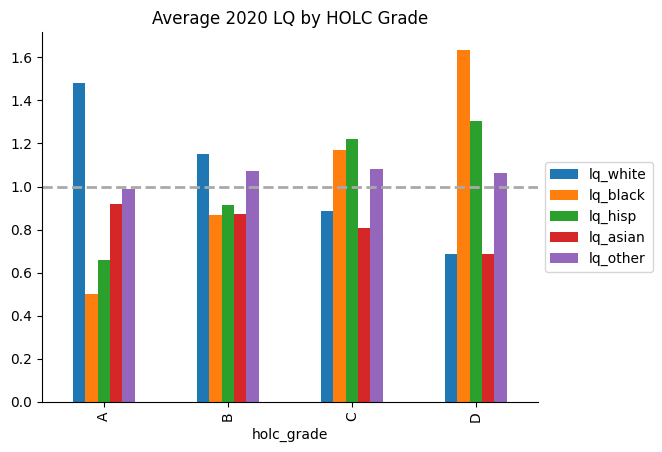

In [7]:
# group by the HOLC grade and keep only percents (to keep comparison fair despite varying population size)
# average percents and LQ scores after grouping, dropping other columns...

by_holc = redline.drop('metro_area', axis = 1).groupby('holc_grade').mean().reset_index()
by_holc = by_holc.drop(['white_pop', 'black_pop', 'hisp_pop', 'asian_pop','other_pop', 'total_pop',
              'surr_area_white_pop', 'surr_area_black_pop','surr_area_hisp_pop', 'surr_area_asian_pop', 
              'surr_area_other_pop','pct_white', 'pct_black', 'pct_hisp', 'pct_asian', 'pct_other',
              'surr_area_pct_white', 'surr_area_pct_black', 'surr_area_pct_hisp', 'surr_area_pct_asian', 'surr_area_pct_other'], axis = 1)


by_holc.plot(x = 'holc_grade', kind = 'bar',
             title = 'Average 2020 LQ by HOLC Grade')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.axhline(y=1, color='darkgray', linestyle='--', linewidth=2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [8]:
redline.columns

Index(['metro_area', 'holc_grade', 'white_pop', 'black_pop', 'hisp_pop',
       'asian_pop', 'other_pop', 'total_pop', 'pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other', 'lq_white', 'lq_black', 'lq_hisp',
       'lq_asian', 'lq_other', 'surr_area_white_pop', 'surr_area_black_pop',
       'surr_area_hisp_pop', 'surr_area_asian_pop', 'surr_area_other_pop',
       'surr_area_pct_white', 'surr_area_pct_black', 'surr_area_pct_hisp',
       'surr_area_pct_asian', 'surr_area_pct_other'],
      dtype='object')

To further explore and visualize the relationship between HOLC grade and demographics, I randomly sampled the `redline` dataset, using a `random state = 1234` for the purposes of reproduceability. Following that, the 5 samples were plotted by percent to keep comparisons equal across the 5 metro areas. 

In [9]:
redline.sample(n = 5, random_state = 1234)

metro_area holc_grade  white_pop  black_pop  hisp_pop  \
169          Evansville, IN-KY          B       1764       1135       159   
355  Phoenix-Mesa-Chandler, AZ          D       2518       2553      9668   
527   Waterloo-Cedar Falls, IA          A       4060        462       325   
221           Jacksonville, FL          B      13253       3868      1312   
516             Utica-Rome, NY          B       5390        418       546   

     asian_pop  other_pop  total_pop  pct_white  pct_black  ...  \
169         11        257       3325      53.04      34.13  ...   
355        368        819      15926      15.81      16.03  ...   
527        129        312       5287      76.79       8.74  ...   
221        380       1120      19931      66.49      19.41  ...   
516        473        318       7146      75.43       5.86  ...   

     surr_area_white_pop  surr_area_black_pop  surr_area_hisp_pop  \
169                63444                12579                3581   
355                55623                12810               74974   
527                33764                11293                4355   
221                82335               105268               19507   
516                64346                11130               10332   

     surr_area_asian_pop  surr_area_other_pop  surr_area_pct_white  \
169                  595                 6068                73.54   
355                 3961                10109                35.32   
527                 1803                 3557                61.64   
221                 5186                10698                36.92   
516                 9132                 4598                64.64   

     surr_area_pct_black  surr_area_pct_hisp  surr_area_pct_asian  \
169                14.58                4.15                 0.69   
355                 8.13               47.61                 2.52   
527                20.62                7.95                 3.29   
221                47.21                8.75                 2.33   
516                11.18               10.38                 9.17   

     surr_area_pct_other  
169                 7.03  
355                 6.42  
527                 6.49  
221                 4.80  
516                 4.62  

[5 rows x 28 columns]

#### Plotting Sample 1: Evansville, IN

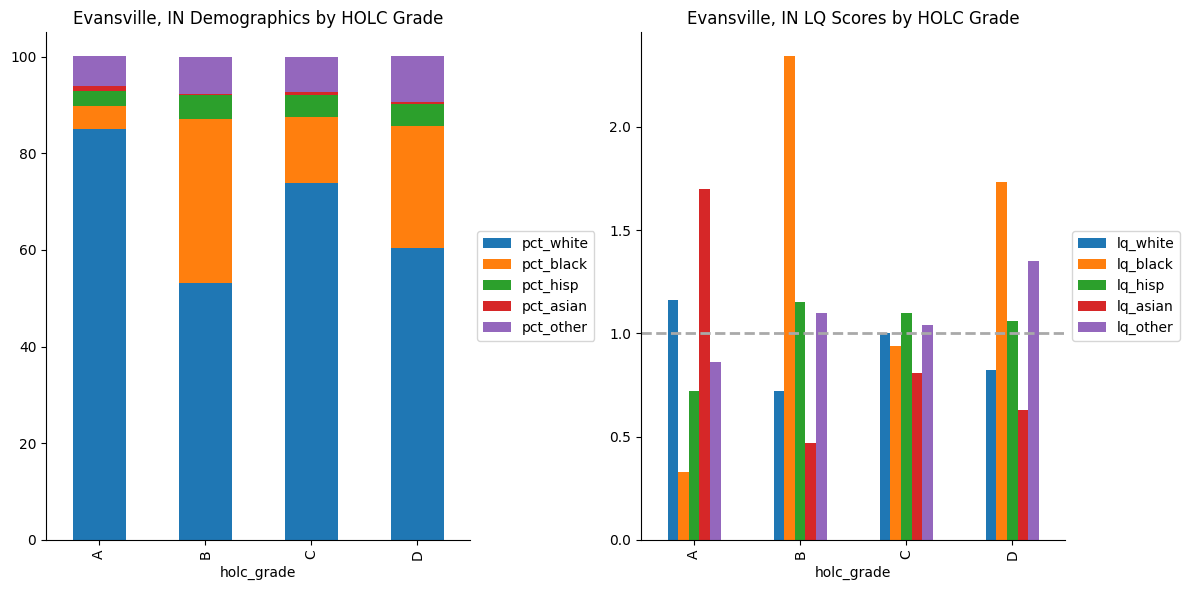

In [10]:
sample1_pct = redline[redline['metro_area']== 'Evansville, IN-KY'][['holc_grade','pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other']]
sample1_lq = redline[redline['metro_area']== 'Evansville, IN-KY'][['holc_grade','lq_white', 'lq_black', 'lq_hisp', 'lq_asian', 'lq_other']]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot
sample1_pct.plot(x='holc_grade', kind='bar', stacked=True, ax=ax[0], 
             title='Evansville, IN Demographics by HOLC Grade')
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Second plot
sample1_lq.plot(x='holc_grade', kind='bar', ax=ax[1], 
             title='Evansville, IN LQ Scores by HOLC Grade')
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].axhline(y=1, color='darkgray', linestyle='--', linewidth=2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Plotting Sample 2: Phoenix, AZ

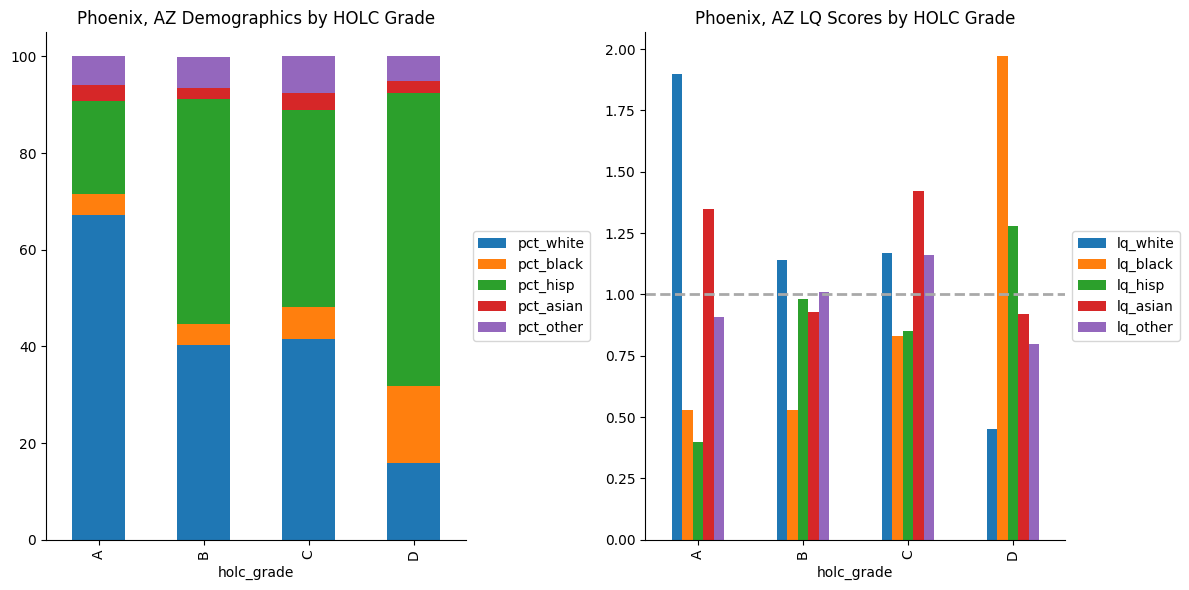

In [11]:
sample2_pct = redline[redline['metro_area']== 'Phoenix-Mesa-Chandler, AZ'][['holc_grade','pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other']]
sample2_lq = redline[redline['metro_area']== 'Phoenix-Mesa-Chandler, AZ'][['holc_grade','lq_white', 'lq_black', 'lq_hisp', 'lq_asian', 'lq_other']]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot
sample2_pct.plot(x='holc_grade', kind='bar', stacked=True, ax=ax[0], 
             title='Phoenix, AZ Demographics by HOLC Grade')
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Second plot
sample2_lq.plot(x='holc_grade', kind='bar', ax=ax[1], 
             title='Phoenix, AZ LQ Scores by HOLC Grade')
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].axhline(y=1, color='darkgray', linestyle='--', 
              linewidth=2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Plotting Sample 3: Waterloo, IA

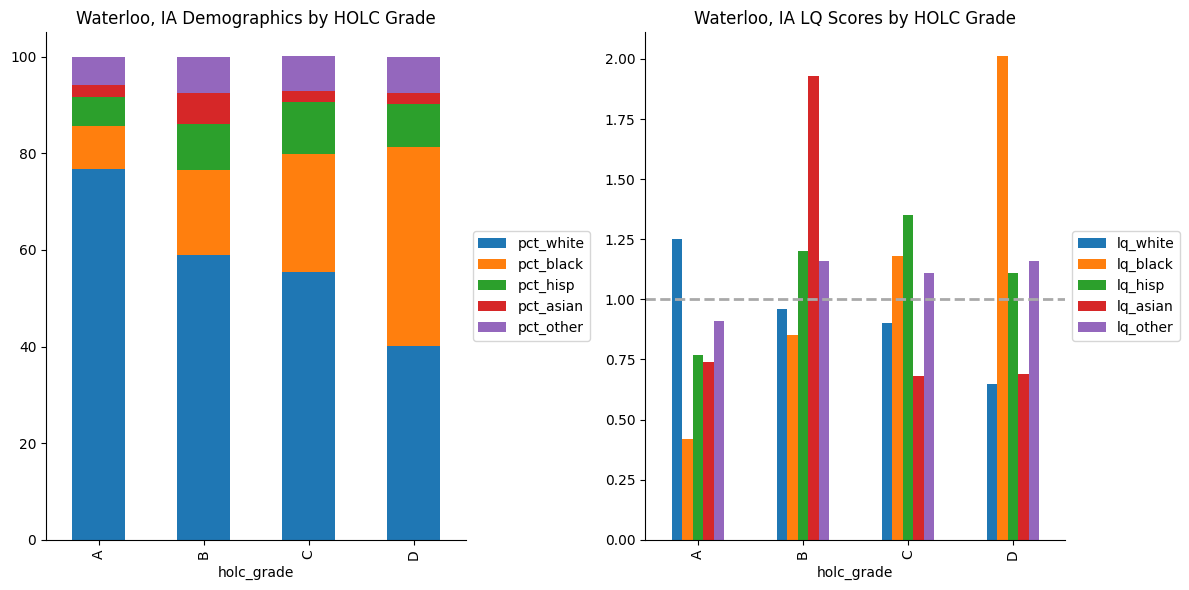

In [12]:
sample3_pct = redline[redline['metro_area']== 'Waterloo-Cedar Falls, IA'][['holc_grade','pct_white', 'pct_black','pct_hisp', 'pct_asian', 'pct_other']]
sample3_lq = redline[redline['metro_area']== 'Waterloo-Cedar Falls, IA'][['holc_grade','lq_white', 'lq_black', 'lq_hisp', 'lq_asian', 'lq_other']]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot
sample3_pct.plot(x='holc_grade', kind='bar', stacked=True, ax=ax[0], 
             title='Waterloo, IA Demographics by HOLC Grade')
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Second plot
sample3_lq.plot(x='holc_grade', kind='bar', ax=ax[1], 
             title='Waterloo, IA LQ Scores by HOLC Grade')
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].axhline(y=1, color='darkgray', linestyle='--', linewidth=2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Plotting Sample 4: Jacksonville, FL

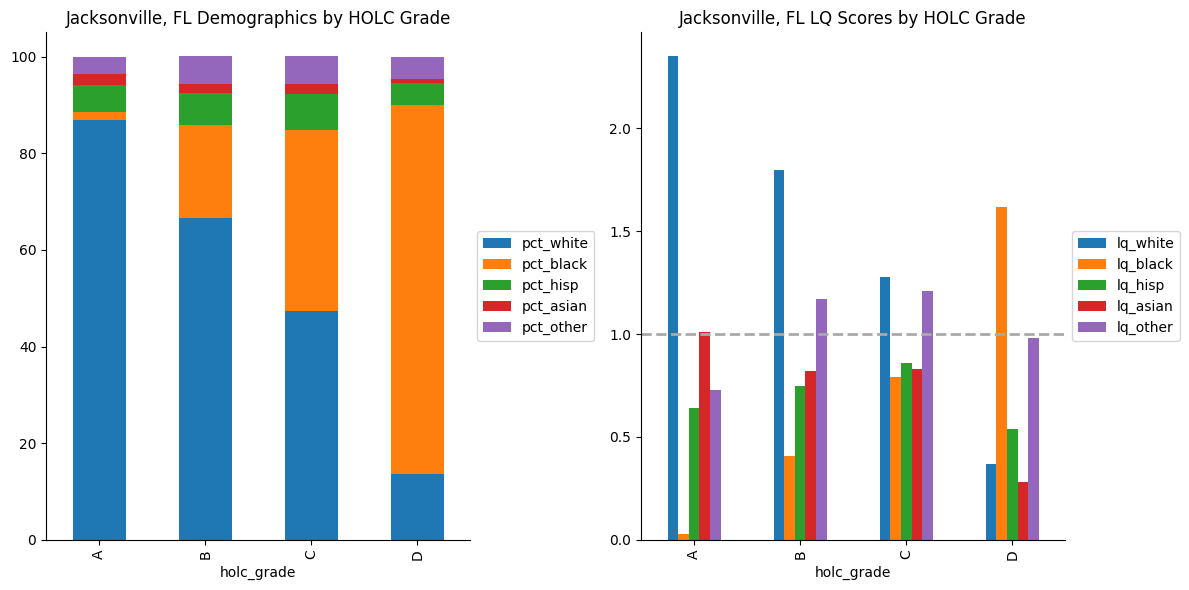

In [13]:
sample4_pct = redline[redline['metro_area']== 'Jacksonville, FL'][['holc_grade','pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other']]
sample4_lq = redline[redline['metro_area']== 'Jacksonville, FL'][['holc_grade','lq_white', 'lq_black', 'lq_hisp', 'lq_asian', 'lq_other']]


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot
sample4_pct.plot(x='holc_grade', kind='bar', stacked=True, ax=ax[0], 
             title='Jacksonville, FL Demographics by HOLC Grade')
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Second plot
sample4_lq.plot(x='holc_grade', kind='bar', ax=ax[1], 
             title='Jacksonville, FL LQ Scores by HOLC Grade')
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].axhline(y=1, color='darkgray', linestyle='--', linewidth=2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Plotting Sample 5: Utica, NY

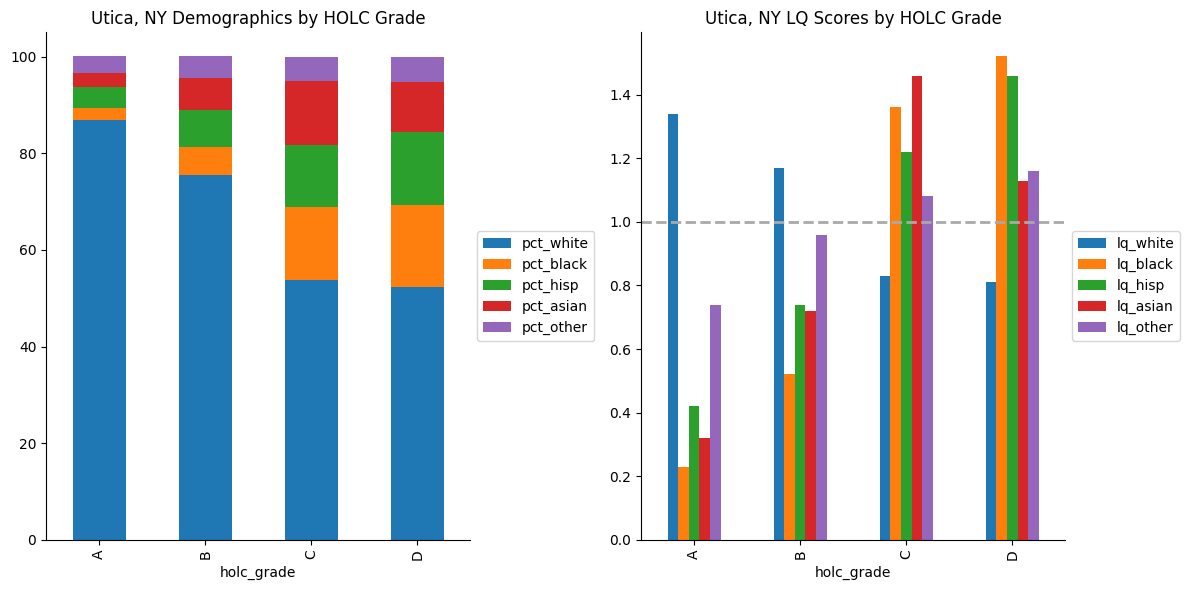

In [14]:
sample5_pct = redline[redline['metro_area']== 'Utica-Rome, NY'][['holc_grade','pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other']]
sample5_lq = redline[redline['metro_area']== 'Utica-Rome, NY'][['holc_grade','lq_white', 'lq_black', 'lq_hisp', 'lq_asian', 'lq_other']]


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot
sample5_pct.plot(x='holc_grade', kind='bar', stacked=True, ax=ax[0], 
             title='Utica, NY Demographics by HOLC Grade')
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Second plot
sample5_lq.plot(x='holc_grade', kind='bar', ax=ax[1], 
             title='Utica, NY LQ Scores by HOLC Grade')
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].axhline(y=1, color='darkgray', linestyle='--', linewidth=2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

The demographic distributions shown for all 5 random samples seem to indicate a pattern where higher HOLC grades have higher proportions of White people with fewer POC. The lower the HOLC grade, the lower proportions of White people and the higher the proportions of POC. This is most notable for Black and Hispanic people, suggesting that the impacts of redlining are still felt almost 80 years after their creation.

Additionally, out of curiousity, I examined the San Diego area:

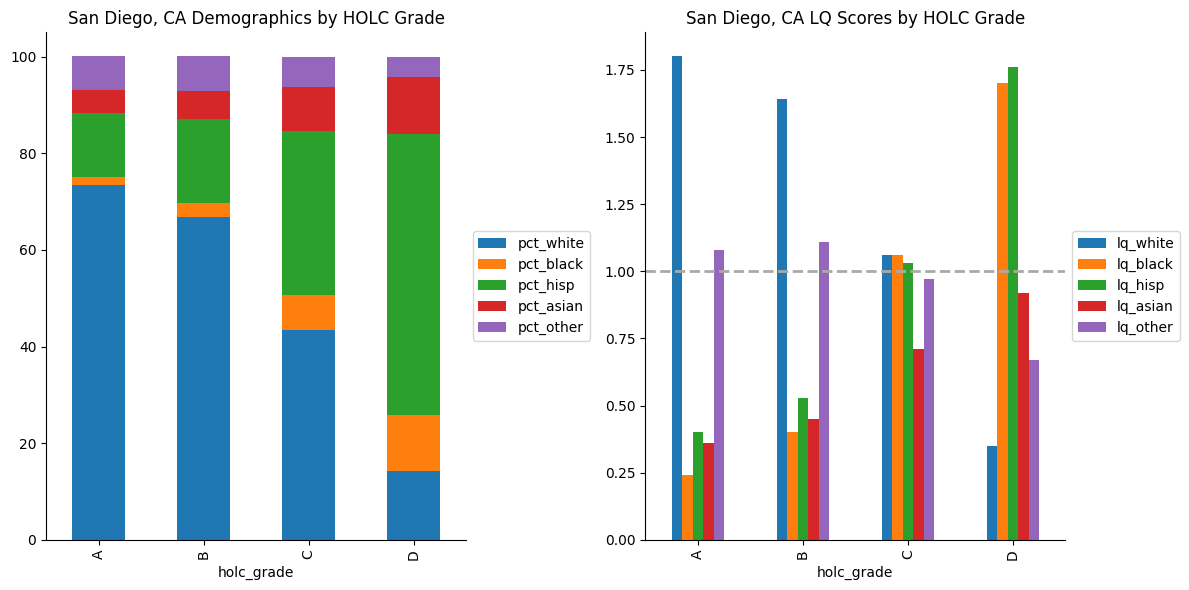

In [15]:
sd_pct = redline[redline['metro_area']== 'San Diego-Chula Vista-Carlsbad, CA'][['holc_grade','pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other']]
sd_lq = redline[redline['metro_area']== 'San Diego-Chula Vista-Carlsbad, CA'][['holc_grade','lq_white', 'lq_black', 'lq_hisp', 'lq_asian', 'lq_other']]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot
sd_pct.plot(x='holc_grade', kind='bar', stacked=True, ax=ax[0], 
             title='San Diego, CA Demographics by HOLC Grade')
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Second plot
sd_lq.plot(x='holc_grade', kind='bar', ax=ax[1], 
             title='San Diego, CA LQ Scores by HOLC Grade')
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].axhline(y=1, color='darkgray', linestyle='--', linewidth=2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

---

### Checking To See if Demographic Distributions Vary By State/Division/Region

#### Creating State/City Columns

To examine whether there were particular states where the impacts of redlining were felt more than others, I first created a new column containing the `metro_area`'s state.

Note that according to the dataset dictionary `metro_area` is the: "Official U.S. Census name of micro- or metropolitan area — defined as 'Core-Based Statistical Areas'. The first city and state listed are used as the display name for each micro/metropolitan area in the story (for example, "Chicago-Naperville-Elgin, IL-IN-WI" is referred to as "Chicago, IL")."


In [16]:
# creating a function that will take the metro_area info and extract the state
def get_state(string):
    new_string = string.split(',')[1].strip()
    # in case there is more than one state, take only the first state 
    if '-' in new_string:
        new_string = new_string.split('-')[0].strip()
    return new_string

#creating a 
def get_city(string):
    new_string = string.split(',')[0].strip()
    # in case there is more than one city, take only the first city 
    if '-' in new_string:
        new_string = new_string.split('-')[0].strip()
    return new_string

# applying get_state function to create a new column 'state'
redline['state'] = redline.metro_area.apply(get_state)

# applying get_city function to create a new column 'city'
redline['city'] = redline.metro_area.apply(get_city)

# reorder columns to have state by the metro_area
redline = redline[['metro_area', 'city', 'state', 'holc_grade', 'white_pop', 'black_pop', 'hisp_pop',
       'asian_pop', 'other_pop', 'total_pop', 'pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other', 'lq_white', 'lq_black', 'lq_hisp',
       'lq_asian', 'lq_other', 'surr_area_white_pop', 'surr_area_black_pop',
       'surr_area_hisp_pop', 'surr_area_asian_pop', 'surr_area_other_pop',
       'surr_area_pct_white', 'surr_area_pct_black', 'surr_area_pct_hisp',
       'surr_area_pct_asian', 'surr_area_pct_other']]

# double-check this was successful
redline.head()

metro_area    city state holc_grade  white_pop  black_pop  \
0                    Akron, OH   Akron    OH          A      24702       8624   
1                    Akron, OH   Akron    OH          B      41531      16499   
2                    Akron, OH   Akron    OH          C      73105      22847   
3                    Akron, OH   Akron    OH          D       6179       6921   
4  Albany-Schenectady-Troy, NY  Albany    NY          A      16989       1818   

   hisp_pop  asian_pop  other_pop  total_pop  ...  surr_area_white_pop  \
0       956        688       1993      36963  ...               304399   
1      2208       3367       4211      67816  ...               304399   
2      3149       6291       7302     112694  ...               304399   
3       567        455       1022      15144  ...               304399   
4      1317       1998       1182      23303  ...               387016   

   surr_area_black_pop  surr_area_hisp_pop  surr_area_asian_pop  \
0                70692               11037                17295   
1                70692               11037                17295   
2                70692               11037                17295   
3                70692               11037                17295   
4                68371               42699                41112   

   surr_area_other_pop  surr_area_pct_white  surr_area_pct_black  \
0                23839                71.24                16.55   
1                23839                71.24                16.55   
2                23839                71.24                16.55   
3                23839                71.24                16.55   
4                40596                66.75                11.79   

   surr_area_pct_hisp  surr_area_pct_asian  surr_area_pct_other  
0                2.58                 4.05                 5.58  
1                2.58                 4.05                 5.58  
2                2.58                 4.05                 5.58  
3                2.58                 4.05                 5.58  
4                7.36                 7.09                 7.00  

[5 rows x 30 columns]

In [17]:
# another double check - sample 1 ('Evansville, IN-KY') should have IN in state if the function was successful
redline[redline['metro_area']== 'Evansville, IN-KY']

metro_area        city state holc_grade  white_pop  black_pop  \
168  Evansville, IN-KY  Evansville    IN          A       4098        232   
169  Evansville, IN-KY  Evansville    IN          B       1764       1135   
170  Evansville, IN-KY  Evansville    IN          C      31500       5833   
171  Evansville, IN-KY  Evansville    IN          D       6788       2838   

     hisp_pop  asian_pop  other_pop  total_pop  ...  surr_area_white_pop  \
168       145         57        292       4824  ...                63444   
169       159         11        257       3325  ...                63444   
170      1939        238       3127      42639  ...                63444   
171       496         49       1066      11238  ...                63444   

     surr_area_black_pop  surr_area_hisp_pop  surr_area_asian_pop  \
168                12579                3581                  595   
169                12579                3581                  595   
170                12579                3581                  595   
171                12579                3581                  595   

     surr_area_other_pop  surr_area_pct_white  surr_area_pct_black  \
168                 6068                73.54                14.58   
169                 6068                73.54                14.58   
170                 6068                73.54                14.58   
171                 6068                73.54                14.58   

     surr_area_pct_hisp  surr_area_pct_asian  surr_area_pct_other  
168                4.15                 0.69                 7.03  
169                4.15                 0.69                 7.03  
170                4.15                 0.69                 7.03  
171                4.15                 0.69                 7.03  

[4 rows x 30 columns]

In order to calculate an "overall" measure of over/under representation for a given city we can use the LQ scores for all demographic groups for all HOLC scores. Since an LQ score of 1 indicates a perfect representation of a given group, we can calculate the squared deviation scores to then calculate a city's LQ variance to get a sense of how equitable a city is overall. These LQ variance scores have been placed in a new table: `metro_area_demographics`

In [18]:
# getting a list of unique metro_areas in the dataset
metro_areas_unique = redline['metro_area'].unique().tolist()

# getting a list of the lq score columns
lq_scores = ['lq_white', 'lq_black', 'lq_hisp','lq_asian', 'lq_other']

In [19]:
# creating a function calc_sqdeviation to compute a given lq's deviation from 1 squared
def calc_sqdeviation(lq):
    return (1-lq)**2

metro_area_demographics = pd.DataFrame()
metro_area_demographics['metro_area'] = metro_areas_unique

# apply get_state and get_city functions for graphing and easier comprehension
metro_area_demographics['city'] = metro_area_demographics['metro_area'].apply(get_city)
metro_area_demographics['state'] = metro_area_demographics['metro_area'].apply(get_state)

In [20]:
lq_variance = []

# loop through each unique metro_area
for area in metro_areas_unique:
    temp_dat = redline[redline['metro_area'] == area]
    temp_arr = []
    
    # loop through each demographic group's LQ scores and append each score into an array
    for demographic in lq_scores:
        temp_arr.extend(temp_dat[demographic].tolist())
    
    # apply the calc_sqdeviation function to the array, sum together, and divide by 20 
    # append the lq_variance of lq scores for the city to the deviations list
    lq_variance.append(np.sum(calc_sqdeviation(np.array(temp_arr)))/20)

# add the variances to the metro_area_demographics
metro_area_demographics['lq_variance'] = lq_variance

In [21]:
metro_area_demographics.sort_values(by = 'lq_variance', ascending=False)

metro_area        city state  lq_variance
51        Huntington-Ashland, WV-KY-OH  Huntington    WV     1.689085
136                   York-Hanover, PA        York    PA     1.003470
45                          Fresno, CA      Fresno    CA     0.750280
137  Youngstown-Warren-Boardman, OH-PA  Youngstown    OH     0.642940
68               Macon-Bibb County, GA       Macon    GA     0.579285
..                                 ...         ...   ...          ...
83                Ogden-Clearfield, UT       Ogden    UT     0.044390
63                         Lincoln, NE     Lincoln    NE     0.044145
112               Sioux City, IA-NE-SD  Sioux City    IA     0.039785
94                          Pueblo, CO      Pueblo    CO     0.037970
40                          Elmira, NY      Elmira    NY     0.033595

[138 rows x 4 columns]

While this provides an overall LQ variance for each metro_area, giving a full sense of its demographic over/underrepresentation, the question at hand is in regards to states. Therefore, some additional wrangling needs to take place.

In [22]:
# creating a new df grouping metro_area_demographics by state, and averaging their LQ variances
state_demographics = metro_area_demographics.drop(['metro_area', 'city'], axis = 1).groupby('state').mean().reset_index()
state_demographics.sort_values(by = 'lq_variance', ascending = True)
len(state_demographics)

38

From the 

In [23]:
fig = px.choropleth(state_demographics,
                    locations='state',
                    locationmode='USA-states',  # Recognizes state names or abbreviations
                    color='lq_variance',
                    scope="usa",  # Focus on the USA
                    color_continuous_scale='Oranges',
                    range_color=[0, 0.7])

fig.update_layout(title_text='Demographic Inequity By State', geo_scope='usa')

fig.show()












---

#### Creating a Region and Division Column

Based on regions defined by [US Census Data](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf#page=2.00), we can also add in each locations' region and divison based on their state.
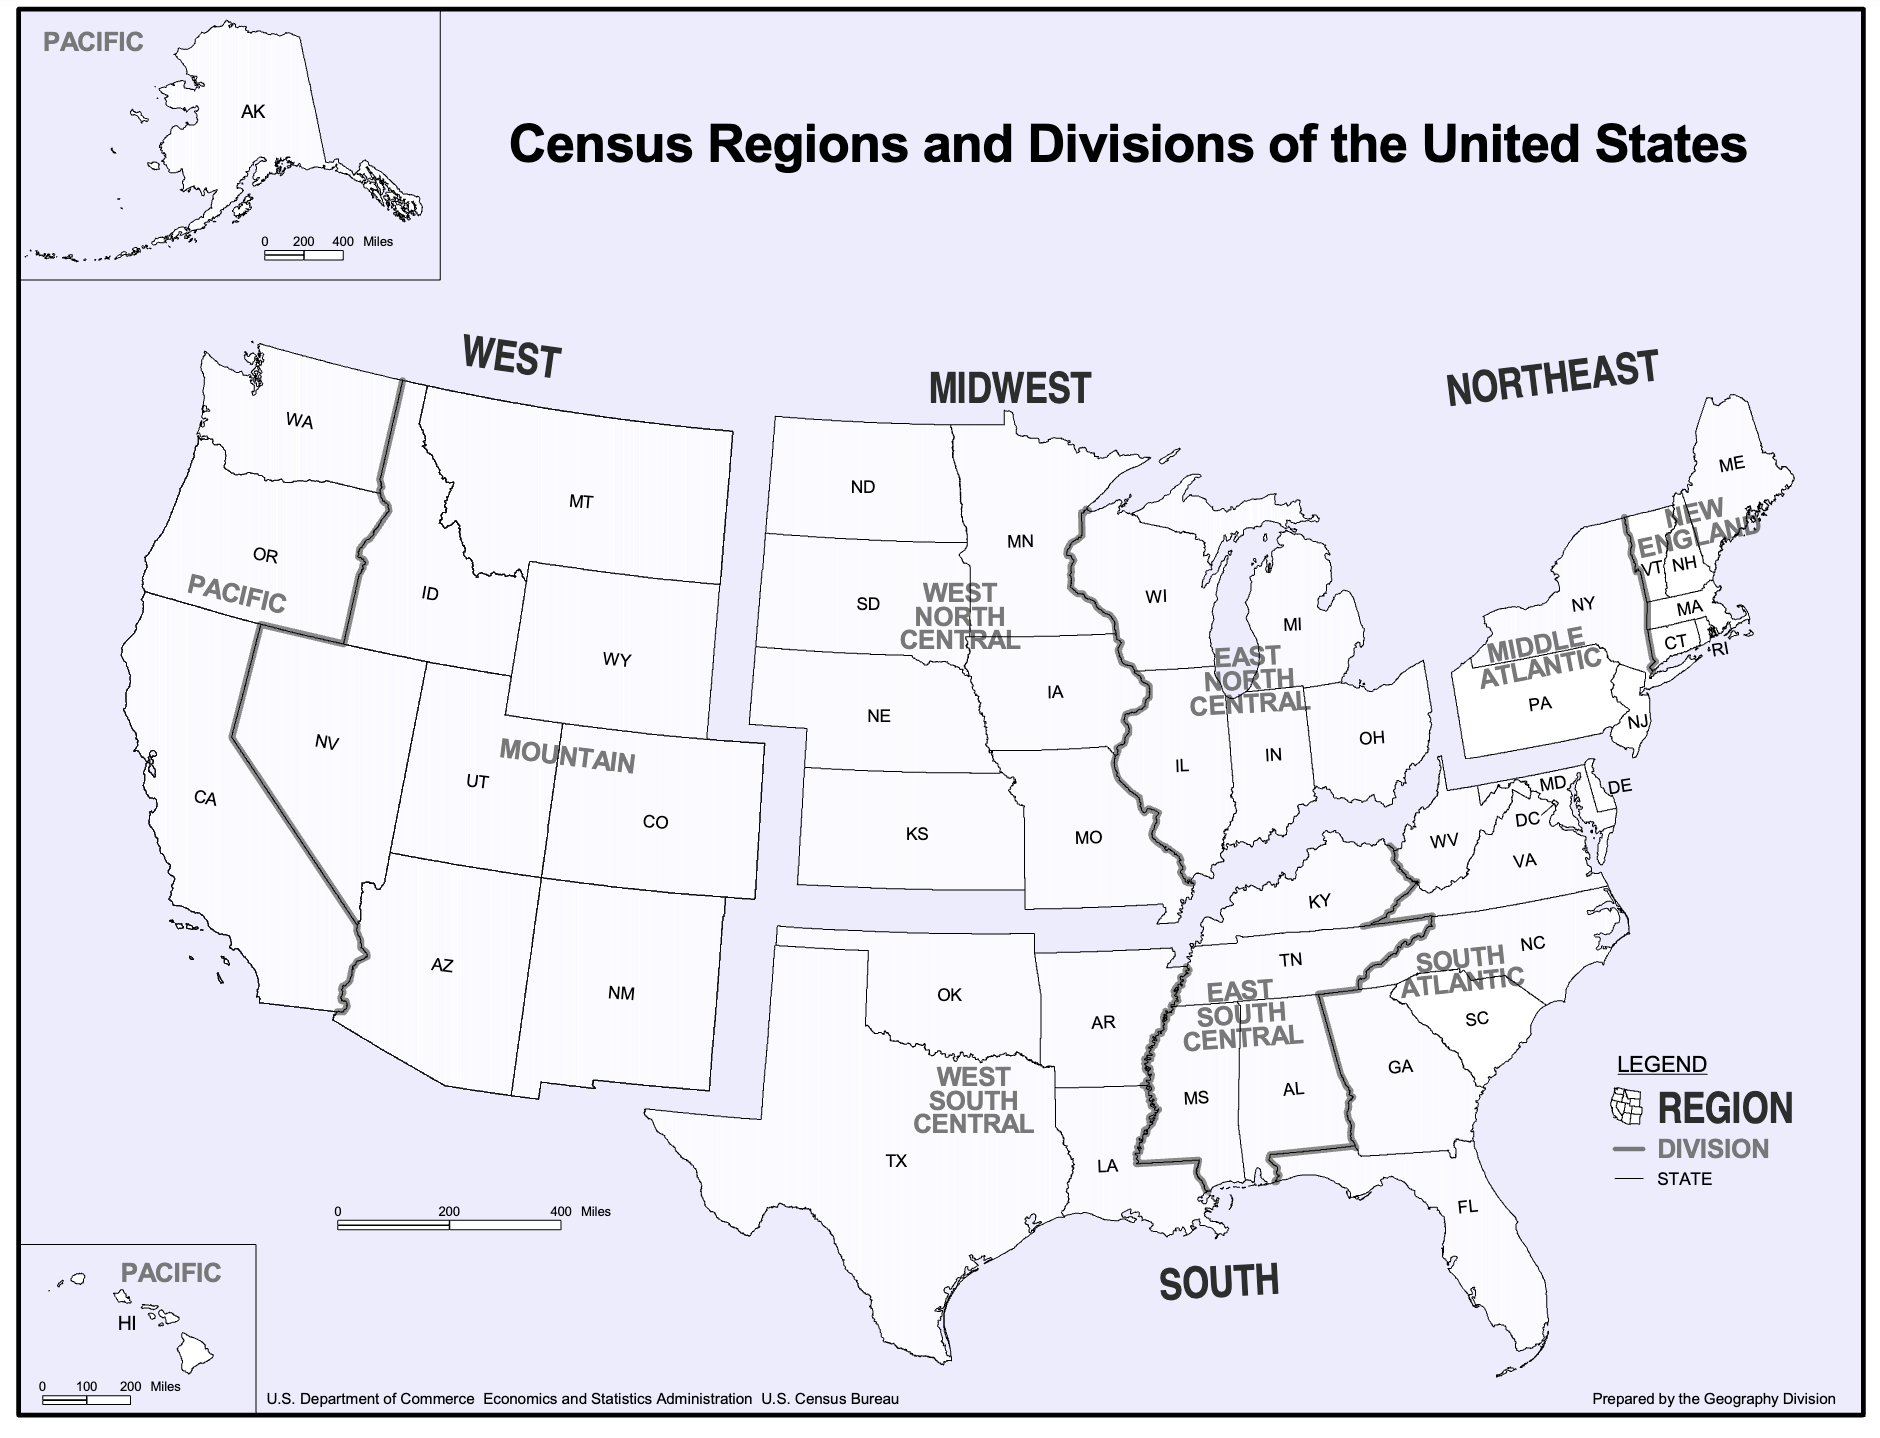

In [24]:
# create a dictionary where state abbreviations are the keys, and the [divison, region] is the value

state_to_region = {
    'WA': ['PACIFIC', 'WEST'],
    'OR': ['PACIFIC', 'WEST'],
    'CA': ['PACIFIC', 'WEST'],
    'HI': ['PACIFIC', 'WEST'],
    'AK': ['PACIFIC', 'WEST'],
    
    'MT': ['MOUNTAIN', 'WEST'],
    'ID': ['MOUNTAIN', 'WEST'],
    'WY': ['MOUNTAIN', 'WEST'],
    'NV': ['MOUNTAIN', 'WEST'],
    'UT': ['MOUNTAIN', 'WEST'],
    'CO': ['MOUNTAIN', 'WEST'],
    'AZ': ['MOUNTAIN', 'WEST'],
    'NM': ['MOUNTAIN', 'WEST'],
    
    
    
    'ND': ['WEST NORTH CENTRAL', 'MIDWEST'],
    'SD': ['WEST NORTH CENTRAL', 'MIDWEST'],
    'MN': ['WEST NORTH CENTRAL', 'MIDWEST'],
    'NE': ['WEST NORTH CENTRAL', 'MIDWEST'],
    'IA': ['WEST NORTH CENTRAL', 'MIDWEST'],
    'KS': ['WEST NORTH CENTRAL', 'MIDWEST'],
    'MO': ['WEST NORTH CENTRAL', 'MIDWEST'],
     
    'WI': ['EAST NORTH CENTRAL', 'MIDWEST'],
    'IL': ['EAST NORTH CENTRAL', 'MIDWEST'],
    'MI': ['EAST NORTH CENTRAL', 'MIDWEST'],
    'IN': ['EAST NORTH CENTRAL', 'MIDWEST'],
    'OH': ['EAST NORTH CENTRAL', 'MIDWEST'],
    
    
    
    'PA': ['MIDDLE ATLANTIC', 'NORTHEAST'],
    'NY': ['MIDDLE ATLANTIC', 'NORTHEAST'],
    'NJ': ['MIDDLE ATLANTIC', 'NORTHEAST'],
    
    'VT': ['NEW ENGLAND', 'NORTHEAST'],
    'ME': ['NEW ENGLAND', 'NORTHEAST'],
    'NH': ['NEW ENGLAND', 'NORTHEAST'],
    'MA': ['NEW ENGLAND', 'NORTHEAST'],
    'CT': ['NEW ENGLAND', 'NORTHEAST'],
    'RI': ['NEW ENGLAND', 'NORTHEAST'],

    
    
    'TX': ['WEST SOUTH CENTRAL', 'SOUTH'],
    'OK': ['WEST SOUTH CENTRAL', 'SOUTH'],
    'AR': ['WEST SOUTH CENTRAL', 'SOUTH'],
    'LA': ['WEST SOUTH CENTRAL', 'SOUTH'],
    
    'AL': ['EAST SOUTH CENTRAL', 'SOUTH'],
    'KY': ['EAST SOUTH CENTRAL', 'SOUTH'],
    'MS': ['EAST SOUTH CENTRAL', 'SOUTH'],
    'TN': ['EAST SOUTH CENTRAL', 'SOUTH'],
    
    'WV': ['SOUTH ATLANTIC', 'SOUTH'],
    'VA': ['SOUTH ATLANTIC', 'SOUTH'],
    'MD': ['SOUTH ATLANTIC', 'SOUTH'],
    'DE': ['SOUTH ATLANTIC', 'SOUTH'],
    'NC': ['SOUTH ATLANTIC', 'SOUTH'],
    'SC': ['SOUTH ATLANTIC', 'SOUTH'],
    'GA': ['SOUTH ATLANTIC', 'SOUTH'],
    'FL': ['SOUTH ATLANTIC', 'SOUTH'],

}

In [25]:
# create a dictionary where the regions are the keys and a list of their states are the values
region_to_state = {
    'South': ['TX','OK','AR','LA', 'AL','KY','MS','TN','WV','VA','MD','DE','NC','SC','GA','FL'],
    'Northeast': ['PA', 'NY', 'NJ', 'VT', 'ME', 'NH', 'MA', 'CT', 'RI'],
    'Midwest': ['ND', 'SD', 'MN', 'NE', 'IA', 'KS', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH'],
    'West': ['WA', 'OR', 'CA', 'HI', 'AK', 'MT', 'ID', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM']
}

# create a dictionary where the divisions are the keys and a list of their states are the values
division_to_state = {
    'South Atlantic': ['WV','VA','MD','DE','NC','SC','GA','FL'],
    'East South Central': ['AL','KY','MS','TN'],
    'West South Central': ['TX','OK','AR','LA'],
    'New England': ['VT', 'ME', 'NH', 'MA', 'CT', 'RI'],
    'Middle Atlantic': ['PA', 'NY', 'NJ'],
    'East North Central': ['WI', 'IL', 'MI', 'IN', 'OH'],
    'West North Central': ['ND', 'SD', 'MN', 'NE', 'IA', 'KS', 'MO'],
    'Mountain': ['MT', 'ID', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM'],
    'Pacific': ['WA', 'OR', 'CA', 'HI', 'AK']
}

In [26]:
# creating a function that maps each state to its divison
def get_division(state):
    return state_to_region[state][0].title()

# creating a function that maps each state to its region
def get_region(state):
    return state_to_region[state][1].title()

In [27]:
# applying get_divison and create a new column: division
redline['division'] = redline['state'].apply(get_division)

# applying get_region and create a new column: region
redline['region'] = redline['state'].apply(get_region)

# reorder columns
redline = redline[['metro_area', 'city', 'state', 'division', 'region', 'holc_grade', 'white_pop', 'black_pop', 'hisp_pop',
       'asian_pop', 'other_pop', 'total_pop', 'pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other', 'lq_white', 'lq_black', 'lq_hisp',
       'lq_asian', 'lq_other', 'surr_area_white_pop', 'surr_area_black_pop',
       'surr_area_hisp_pop', 'surr_area_asian_pop', 'surr_area_other_pop',
       'surr_area_pct_white', 'surr_area_pct_black', 'surr_area_pct_hisp',
       'surr_area_pct_asian', 'surr_area_pct_other']]

# add an order to regions a general west -> east, north -> south for easier interpretation of plots
redline['region'] = pd.Categorical(redline['region'], categories=['West', 'Midwest', 'Northeast', 'South'], ordered=True)


In [28]:
by_region= redline.drop(['metro_area', 'city', 'state', 'division'], axis = 1).groupby(['region', 'holc_grade']).mean()
by_region = by_region[['lq_white', 'lq_black', 'lq_hisp','lq_asian', 'lq_other']].reset_index()

fig = px.bar(by_region, x='region', y ='lq_white', color='holc_grade', barmode='group')
fig.update_layout(
    title='White LQ Scores by HOLC Grade and Region',
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Removes the background
)
fig.show()

In [29]:
fig = px.bar(by_region, x='region', y ='lq_black', color='holc_grade', barmode='group')
fig.update_layout(
    title='Black LQ Scores by HOLC Grade and Region',
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Removes the background
)
fig.show()

In [30]:
fig = px.bar(by_region, x='region', y ='lq_hisp', color='holc_grade', barmode='group')
fig.update_layout(
    title='Hispanic LQ Scores by HOLC Grade and Region',
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Removes the background
)
fig.show()

In [31]:
fig = px.bar(by_region, x='region', y ='lq_asian', color='holc_grade', barmode='group')
fig.update_layout(
    title='Asian LQ Scores by HOLC Grade and Region',
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Removes the background
)
fig.show()

In [32]:
fig = px.bar(by_region, x='region', y ='lq_other', color='holc_grade', barmode='group')
fig.update_layout(
    title='Other LQ Scores by HOLC Grade and Region',
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Removes the background
)
fig.show()

---


### Division and Region Demographic Equity by LQ Variance

In [33]:
# adding divisions and regions to the metro_area_demographics dataset
metro_area_demographics['division']= metro_area_demographics.state.apply(get_division)
metro_area_demographics['region' ]= metro_area_demographics.state.apply(get_region)

metro_area_demographics

metro_area        city state  lq_variance  \
0                            Akron, OH       Akron    OH     0.233570   
1          Albany-Schenectady-Troy, NY      Albany    NY     0.406110   
2    Allentown-Bethlehem-Easton, PA-NJ   Allentown    PA     0.059175   
3                          Altoona, PA     Altoona    PA     0.149715   
4                         Amarillo, TX    Amarillo    TX     0.190055   
..                                 ...         ...   ...          ...   
133                    Wheeling, WV-OH    Wheeling    WV     0.241125   
134                        Wichita, KS     Wichita    KS     0.136530   
135                  Winston-Salem, NC     Winston    NC     0.321435   
136                   York-Hanover, PA        York    PA     1.003470   
137  Youngstown-Warren-Boardman, OH-PA  Youngstown    OH     0.642940   

               division     region  
0    East North Central    Midwest  
1       Middle Atlantic  Northeast  
2       Middle Atlantic  Northeast  
3       Middle Atlantic  Northeast  
4    West South Central      South  
..                  ...        ...  
133      South Atlantic      South  
134  West North Central    Midwest  
135      South Atlantic      South  
136     Middle Atlantic  Northeast  
137  East North Central    Midwest  

[138 rows x 6 columns]

In [34]:
# Get a table of division demographic inequity 

division_demographics = metro_area_demographics.drop(['metro_area', 'city', 'state', 'region'], axis = 1).groupby('division').mean().reset_index()
division_demographics.rename({'lq_variance':'division_lq_variance'}, axis = 1, inplace = True)
division_demographics.sort_values(by = 'division_lq_variance', ascending = True)

division  division_lq_variance
3            Mountain              0.113088
7  West North Central              0.121754
0  East North Central              0.200134
4         New England              0.204770
8  West South Central              0.224088
5             Pacific              0.239293
2     Middle Atlantic              0.262642
1  East South Central              0.273930
6      South Atlantic              0.311730

In [35]:
# Get a table of region demographic inequity 

region_demographics = metro_area_demographics.drop(['metro_area', 'city', 'state', 'division'], axis = 1).groupby('region').mean().reset_index()
region_demographics.rename({'lq_variance':'region_lq_variance'}, axis = 1, inplace = True)
region_demographics.sort_values(by = 'region_lq_variance', ascending = True)

region  region_lq_variance
0    Midwest            0.175052
3       West            0.197225
1  Northeast            0.248174
2      South            0.278011

In [36]:
# to plot by division/region, apply the get_division and get_region functions to make new columns by state

temp_state_dem = state_demographics
temp_state_dem['division'] = temp_state_dem.state.apply(get_division)
temp_state_dem['region'] = temp_state_dem.state.apply(get_region)

# create dictionaries where divisons/regions are the keys and division lq variance are the values
division_values = dict(division_demographics.sort_values(by = 'division_lq_variance', ascending = True).values)
region_values = dict(region_demographics.sort_values(by = 'region_lq_variance', ascending = True).values)

# create a list of the states from the temp_state_dem dataset
state_division = temp_state_dem['division'].to_list()
state_region = temp_state_dem['region'].to_list()

# loop through the divisions, and append its respective division lq variance to a list, create a new column from that list
temp_lst = []
for division in state_division:
    temp_lst.append(division_values[division])
temp_state_dem['division_lq_variance'] = temp_lst

# loop through the divisions, and append its respective division lq variance to a list, create a new column from that list
temp_lst = []
for region in state_region:
    temp_lst.append(region_values[region])
temp_state_dem['region_lq_variance'] = temp_lst

temp_state_dem.head()


state  lq_variance            division region  division_lq_variance  \
0    AL     0.322798  East South Central  South              0.273930   
1    AR     0.218440  West South Central  South              0.224088   
2    AZ     0.170895            Mountain   West              0.113088   
3    CA     0.297331             Pacific   West              0.239293   
4    CO     0.086015            Mountain   West              0.113088   

   region_lq_variance  
0            0.278011  
1            0.278011  
2            0.197225  
3            0.197225  
4            0.197225

In [37]:
# plot division lq variances
fig = px.choropleth(temp_state_dem,
                    locations='state',
                    locationmode='USA-states',  # This still works for regions
                    hover_name='division',  # Display region name on hover
                    color='division_lq_variance',
                    scope="usa",  # Focus on the USA
                    color_continuous_scale='Oranges',
                    range_color=[0, 0.7])

fig.update_layout(title_text='US Divisions LQ Variance', geo_scope='usa')

# Show the map
fig.show()

In [38]:
# plot region lq variances
fig = px.choropleth(temp_state_dem,
                    locations='state',
                    locationmode='USA-states',  # This still works for regions
                    hover_name='region',  # Display region name on hover
                    color='region_lq_variance',
                    scope="usa",  # Focus on the USA
                    color_continuous_scale='Oranges',
                    range_color=[0, 0.7])

fig.update_layout(title_text='US Region LQ Variance', geo_scope='usa')

# Show the map
fig.show()

---
### What is going on in West Virginia?


In [39]:
metro_area_demographics[metro_area_demographics['state'] == 'WV']

metro_area        city state  lq_variance  \
20                 Charleston, WV  Charleston    WV     0.140800   
51   Huntington-Ashland, WV-KY-OH  Huntington    WV     1.689085   
133               Wheeling, WV-OH    Wheeling    WV     0.241125   

           division region  
20   South Atlantic  South  
51   South Atlantic  South  
133  South Atlantic  South

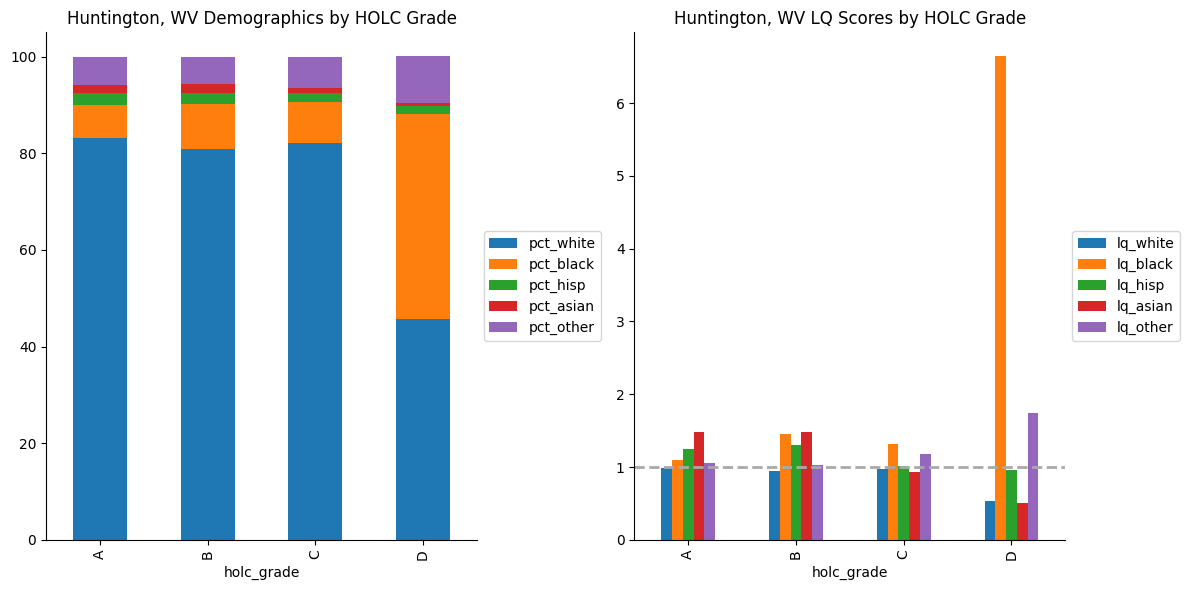

In [40]:
huntington_pct = redline[redline['metro_area'] == 'Huntington-Ashland, WV-KY-OH'][['holc_grade','pct_white', 'pct_black',
       'pct_hisp', 'pct_asian', 'pct_other']]
huntington_lq = redline[redline['metro_area'] == 'Huntington-Ashland, WV-KY-OH'][['holc_grade','lq_white', 'lq_black', 'lq_hisp', 'lq_asian', 'lq_other']]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot
huntington_pct.plot(x='holc_grade', kind='bar', stacked=True, ax=ax[0], 
             title='Huntington, WV Demographics by HOLC Grade')
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Second plot
huntington_lq.plot(x='holc_grade', kind='bar', ax=ax[1], 
             title='Huntington, WV LQ Scores by HOLC Grade')
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].axhline(y=1, color='darkgray', linestyle='--', linewidth=2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [41]:
metro_area_demographics

metro_area        city state  lq_variance  \
0                            Akron, OH       Akron    OH     0.233570   
1          Albany-Schenectady-Troy, NY      Albany    NY     0.406110   
2    Allentown-Bethlehem-Easton, PA-NJ   Allentown    PA     0.059175   
3                          Altoona, PA     Altoona    PA     0.149715   
4                         Amarillo, TX    Amarillo    TX     0.190055   
..                                 ...         ...   ...          ...   
133                    Wheeling, WV-OH    Wheeling    WV     0.241125   
134                        Wichita, KS     Wichita    KS     0.136530   
135                  Winston-Salem, NC     Winston    NC     0.321435   
136                   York-Hanover, PA        York    PA     1.003470   
137  Youngstown-Warren-Boardman, OH-PA  Youngstown    OH     0.642940   

               division     region  
0    East North Central    Midwest  
1       Middle Atlantic  Northeast  
2       Middle Atlantic  Northeast  
3       Middle Atlantic  Northeast  
4    West South Central      South  
..                  ...        ...  
133      South Atlantic      South  
134  West North Central    Midwest  
135      South Atlantic      South  
136     Middle Atlantic  Northeast  
137  East North Central    Midwest  

[138 rows x 6 columns]

In [42]:
# remove the Huntington-Ashland, WV-KY-OH entry from the dataset
new_metro_area_demographics = metro_area_demographics[metro_area_demographics['metro_area'] != 'Huntington-Ashland, WV-KY-OH']

# create a new dataset with the state lq variance, without Huntington-Ashland, WV-KY-OH entry from the dataset
new_state_demographics = new_metro_area_demographics.drop(['metro_area', 'city', 'division', 'region'], axis = 1).groupby('state').mean().reset_index()
new_state_demographics.rename({'lq_variance': 'state_lq_variance'}, axis = 1, inplace = True)
new_state_demographics.sort_values(by = 'state', ascending = True)

state  state_lq_variance
0     AL           0.322798
1     AR           0.218440
2     AZ           0.170895
3     CA           0.297331
4     CO           0.086015
5     CT           0.304915
6     FL           0.342768
7     GA           0.276953
8     IA           0.098249
9     IL           0.140579
10    IN           0.189189
11    KS           0.114725
12    KY           0.199458
13    LA           0.217280
14    MA           0.122860
15    MD           0.057375
16    MI           0.168880
17    MN           0.134102
18    MO           0.160264
19    MS           0.509615
20    NC           0.272092
21    NE           0.092008
22    NH           0.136240
23    NJ           0.478085
24    NY           0.198504
25    OH           0.274982
26    OK           0.169997
27    OR           0.087245
28    PA           0.277278
29    RI           0.136685
30    SC           0.149870
31    TN           0.215592
32    TX           0.240018
33    UT           0.111258
34    VA           0.201569
35    WA           0.112187
36    WI           0.147368
37    WV           0.190962

In [43]:
fig = px.choropleth(new_state_demographics,
                    locations='state',
                    locationmode='USA-states',  # Recognizes state names or abbreviations
                    color='state_lq_variance',
                    scope="usa",  # Focus on the USA
                    color_continuous_scale='Oranges',
                    range_color=[0, 0.7])

fig.update_layout(title_text='Demographic Inequity by State (Without VW Metro Area)', geo_scope='usa')

fig.show()

Double Check that there are no outliers in MS and NJ that are contributing to this:

In [44]:
metro_area_demographics[metro_area_demographics['state'] == 'MS']

metro_area     city state  lq_variance            division region
54  Jackson, MS  Jackson    MS     0.509615  East South Central  South

In [45]:
metro_area_demographics[metro_area_demographics['state'] == 'NJ']

metro_area           city state  lq_variance  \
7    Atlantic City-Hammonton, NJ  Atlantic City    NJ     0.521725   
127        Trenton-Princeton, NJ        Trenton    NJ     0.434445   

            division     region  
7    Middle Atlantic  Northeast  
127  Middle Atlantic  Northeast

In [46]:
# Get a table of division demographic inequity 

new_division_demographics = new_metro_area_demographics.drop(['metro_area', 'city', 'state', 'region'], axis = 1).groupby('division').mean().reset_index()
new_division_demographics.rename({'lq_variance':'division_lq_variance'}, axis = 1, inplace = True)
new_division_demographics.sort_values(by = 'division_lq_variance', ascending = True)

division  division_lq_variance
3            Mountain              0.113088
7  West North Central              0.121754
0  East North Central              0.200134
4         New England              0.204770
8  West South Central              0.224088
5             Pacific              0.239293
6      South Atlantic              0.246142
2     Middle Atlantic              0.262642
1  East South Central              0.273930

In [47]:
# Get a table of region demographic inequity 

new_region_demographics = new_metro_area_demographics.drop(['metro_area', 'city', 'state', 'division'], axis = 1).groupby('region').mean().reset_index()
new_region_demographics.rename({'lq_variance':'region_lq_variance'}, axis = 1, inplace = True)
new_region_demographics.sort_values(by = 'region_lq_variance', ascending = True)

region  region_lq_variance
0    Midwest            0.175052
3       West            0.197225
2      South            0.245941
1  Northeast            0.248174

In [48]:
# to plot by division/region, apply the get_division and get_region functions to make new columns by state

temp_state_dem = new_state_demographics
temp_state_dem['division'] = temp_state_dem.state.apply(get_division)
temp_state_dem['region'] = temp_state_dem.state.apply(get_region)

# create dictionaries where divisons/regions are the keys and division lq variance are the values
division_values = dict(new_division_demographics.sort_values(by = 'division_lq_variance', ascending = True).values)
region_values = dict(new_region_demographics.sort_values(by = 'region_lq_variance', ascending = True).values)

# create a list of the states from the temp_state_dem dataset
state_division = temp_state_dem['division'].to_list()
state_region = temp_state_dem['region'].to_list()

# loop through the divisions, and append its respective division lq variance to a list, create a new column from that list
temp_lst = []
for division in state_division:
    temp_lst.append(division_values[division])
temp_state_dem['division_lq_variance'] = temp_lst

# loop through the divisions, and append its respective division lq variance to a list, create a new column from that list
temp_lst = []
for region in state_region:
    temp_lst.append(region_values[region])
temp_state_dem['region_lq_variance'] = temp_lst

temp_state_dem.head()

state  state_lq_variance            division region  division_lq_variance  \
0    AL           0.322798  East South Central  South              0.273930   
1    AR           0.218440  West South Central  South              0.224088   
2    AZ           0.170895            Mountain   West              0.113088   
3    CA           0.297331             Pacific   West              0.239293   
4    CO           0.086015            Mountain   West              0.113088   

   region_lq_variance  
0            0.245941  
1            0.245941  
2            0.197225  
3            0.197225  
4            0.197225

In [49]:
# plot division lq variances
fig = px.choropleth(temp_state_dem,
                    locations='state',
                    locationmode='USA-states',  # This still works for regions
                    hover_name='division',  # Display region name on hover
                    color='division_lq_variance',
                    scope="usa",  # Focus on the USA
                    color_continuous_scale='Oranges',
                    range_color=[0, 0.7])

fig.update_layout(title_text='Demographic Inequity by Division (Without VW Metro Area)', geo_scope='usa')

# Show the map
fig.show()

In [50]:
# plot region lq variances
fig = px.choropleth(temp_state_dem,
                    locations='state',
                    locationmode='USA-states',  # This still works for regions
                    hover_name='region',  # Display region name on hover
                    color='region_lq_variance',
                    scope="usa",  # Focus on the USA
                    color_continuous_scale='Oranges',
                    range_color=[0, 0.7])

fig.update_layout(title_text='Demographic Inequity by Region (Without VW Metro Area)', geo_scope='usa')

# Show the map
fig.show()